# **Taller de GPS**
### Guido Salazar y Laura Sánchez

## Algoritmos

### Newton Rhapson

In [1]:
import numpy as np
import sympy as sym
from pprint import pprint

def newton_rhapson(f, x0, tol=0.0001, iter=50):
  """
  Función que calcula el cero de una función de Rn
  Entradas: f: Función en Rn
            x0: valor inicial
            tol: tolerancia
            iter: maximo de iteraciones
  Salida: ans: tupla con el valor obtenido y un mensaje en caso de que el metodo
               si converge, falla o no converge
  """
  simb_x = [sym.Symbol("x" + str(i)) for i in range(len(x0))] #Creación de variables simbolicas igual a la cantidad de elementos en el valor inicial
  mat = sym.Matrix(f(simb_x)) #sympy matrix para la función f de numpy
  JF = sym.lambdify([simb_x], mat.jacobian(simb_x)) #Hallar la jacobiana y transformarla en un array de numpy
  i, y, ans, flag = 0, x0, None, True #Creación del iterador, respuesta del metodo, salida, y una bandera por si el metodo falla
  while np.linalg.norm(f(x0)) >= tol and i < iter and flag: #Mientras el resultado cumpla con la tolerancia, o no se halla llegado al numero de iteraciones o la bandera sea cierta
    if (np.linalg.det(JF(x0)) == 0): ans, flag = (np.array([]), "Error"), False #Si la jacobiana es 0 el metodo falla y la bandera de fallo se activa
    else: #Creación del sistema de ecuacions F(x0) = -JF(x0)(x1 - x0) => Ay = b
      b = f(x0)
      A = -JF(x0)

      #Resolver el sistemas de ecuaciones usando QR Ax=b => QRx=b => Rx = Q^{-1}b => Rx = Q^Tb
      Q,R = np.linalg.qr(A) # qr decomposition of A
      QT = np.transpose(Q)
      y = np.dot(QT, b)
      y = np.linalg.solve(R, y)
      x0 = y + x0
      i += 1

  if i >= iter and flag: ans = (np.array(x0), "No encontrado")
  elif flag: ans = (np.array(x0), "Encontrado")
  return ans

### Metodo de Gauss Newton

In [3]:
import numpy as np
import sympy as sym
from pprint import pprint

def gauss_newton(r, x0, tol=0.001, iter=1000, fixed_lambda=50):
  """
  Función que calcula los parametros de una función usando minimos cuadrados no
  lineales
  Entradas: r: Función en Rn -> Rm con los errores relativos
            x0: valor inicial
            tol: tolerancia
            iter: maximo de iteraciones
  Salida: ans: tupla con los valores que solución el sistema de ecuaciones de
               los errores relativos obtenido y un mensaje en caso de que el
               metodo si converge, falla o no converge
  """
  simb_x = [sym.Symbol("x" + str(i)) for i in range(len(x0))] #Creación de variables simbolicas igual a la cantidad de elementos en el valor inicial
  mat = sym.Matrix(r(simb_x)) #sympy matrix para la función f de numpy
  Dr = sym.lambdify([simb_x], mat.jacobian(simb_x)) #Hallar la jacobiana y transformarla en un array de numpy
  i, y, ans, flag = 0, x0, None, True #Creación del iterador, respuesta del metodo, salida, y una bandera por si el metodo falla
  delta = np.array([1 for _ in range(len(x0))])
  while np.linalg.norm(delta) >= tol and i < iter and flag: #Mientras el resultado cumpla con la tolerancia, o no se halla llegado al numero de iteraciones o la bandera sea cierta
      #Sea A = Dr(x0)
      #Creación del sistema de ecuacions (ATA+lambda*diag(A^T, T))delta = ATr(x) => Ay = b
      # x_k+1 = x_k + delta
      A = Dr(x0)
      b = r(x0)
      b = -np.dot(np.transpose(A), b)
      A = np.dot(np.transpose(A), A)
      A += fixed_lambda*np.diag(np.diag(A))
      #Resolver el sistemas de ecuaciones usando QR Ax=b => QRx=b => Rx = Q^{-1}b => Rx = Q^Tb
      Q,R = np.linalg.qr(A) # qr decomposition of A
      QT = np.transpose(Q)
      y = np.dot(QT, b)
      delta = np.linalg.solve(R, y)
      x0 = np.array(delta + x0)
      i += 1
  if i >= iter and flag: ans = (np.array(x0), "No encontrado")
  elif flag: ans = (np.array(x0), "Encontrado")
  return ans

## Punto 1

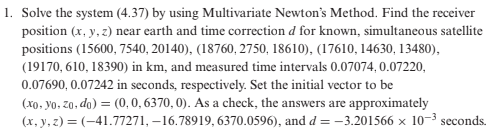

In [4]:
#Sea U = [A, B, C, t]
U = [(15600,7540,20140,0.07074), (18760,2750,18610,0.07220),
     (17610,14630,13480,0.07690),(19170,610,18390,0.07242)]
#The nominal speed of the signal is the speed of light, c ≈ 299792.458 km/sec
c = 299792.458

#Sea r((x,y,z)) = [r_1((x,y,z)), ..., r_n((x,y,z))]
#donde r_i = sqrt((A_i - x)^2+(B_i - y)^2+((Z_i - z)^2)) - c(t_1-d)
f = lambda x, i: sum([(U[i][j] - x[j])**2 for j in range(len(x)-1)])
r = lambda x: np.array([f(x,i)**(1/2) - c*(U[i][3]-x[3]) for i in range(len(U))])

x, msg = newton_rhapson(r, np.array([0, 0, 6370,0]), tol=0.001, iter=1000)

print(msg)
u = [sym.Symbol("x"), sym.Symbol("y"), sym.Symbol("z"), sym.Symbol("d")]
print(x)

for var, val in zip(u, x):
  print(f"{var} = {val}")


Encontrado
[-4.17727094e+01 -1.67891940e+01  6.37005956e+03 -3.20156583e-03]
x = -41.77270940467917
y = -16.789194039796833
z = 6370.059559201509
d = -0.003201565828998019


## Punto 2

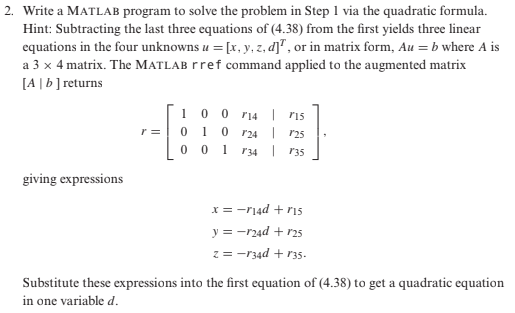

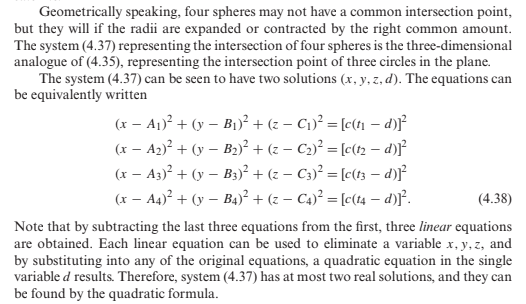

### Primera Ecuación

$
x^2 - 2A_1x + A_1^2 + y^2 - 2B_1y + B_1^2 + z^2 - 2C_1z + C_1^2 = c^2d^2 - 2c^2t_1d + c^2t_1^2 \\
-(x^2 - 2A_2x + A_2^2 + y^2 - 2B_2y + B_2^2 + z^2 - 2C_2z + C_2^2 = c^2d^2 - 2c^2t_2d + c^2t_2^2) \\
⇒
- 2A_1x + 2A_2x + A_1^2 - A_2^2 - 2B_1y + 2B_2y + B_1^2 - B_2^2 - 2C_1z + 2C_2z + C_1^2 - C_2^2 = - 2c^2t_1d + 2c^2t_2d + c^2t_1^2 - c^2t_2^2 \\
⇒ x(2A_2-2A_1) + (A_1^2 - A_2^2) + y(2B_2 - 2B_1) + (B_1^2 - B_2^2) + z(2C_2 - 2C_1) + (C_1^2 - C_2^2) = d(2c^2t_2 - 2c^2t_1) + (c^2t_1^2 - c^2t_2^2) \\
⇒A_{12}x + B_{12}y + C_{12}z - T_{12}d = r_{12} \\
$

In [5]:
A12 = 2*U[1][0] - 2*U[0][0]
B12 = 2*U[1][1] - 2*U[0][1]
C12 = 2*U[1][2] - 2*U[0][2]
T12 = (c**2)*(2*U[1][3] - 2*U[0][3])
r12 = (c**2)*(U[0][3]**2 - U[1][3]**2) - (U[0][0]**2 - U[1][0]**2) - (U[0][1]**2 - U[1][1]**2) - (U[0][2]**2 - U[1][2]**2)

### Segunda Ecuación

$
x^2 - 2A_1x + A_1^2 + y^2 - 2B_1y + B_1^2 + z^2 - 2C_1z + C_1^2 = c^2d^2 - 2c^2t_1d + c^2t_1^2 \\
-(x^2 - 2A_3x + A_3^2 + y^2 - 2B_3y + B_3^2 + z^2 - 2C_3z + C_3^2 = c^2d^2 - 2c^2t_3d + c^2t_3^2) \\
⇒
- 2A_1x + 2A_3x + A_1^2 - A_3^2 - 2B_1y + 2B_3y + B_1^2 - B_3^2 - 2C_1z + 2C_3z + C_1^2 - C_3^2 = - 2c^2t_1d + 2c^2t_3d + c^2t_1^2 - c^2t_3^2 \\
⇒ x(2A_3-2A_1) + (A_1^2 - A_3^2) + y(2B_3 - 2B_1) + (B_1^2 - B_3^2) + z(2C_3 - 2C_1) + (C_1^2 - C_3^2) = d(2c^2t_3 - 2c^2t_1) + (c^2t_1^2 - c^2t_3^2) \\
⇒A_{13}x + B_{13}y + C_{13}z - T_{13}d = r_{13}
$

In [6]:
A13 = 2*U[2][0] - 2*U[0][0]
B13 = 2*U[2][1] - 2*U[0][1]
C13 = 2*U[2][2] - 2*U[0][2]
T13 = (c**2)*(2*U[2][3] - 2*U[0][3])
r13 = (c**2)*(U[0][3]**2 - U[2][3]**2) - (U[0][0]**2 - U[2][0]**2) - (U[0][1]**2 - U[2][1]**2) - (U[0][2]**2 - U[2][2]**2)

### Tercera Ecuación

$
x^2 - 2A_1x + A_1^2 + y^2 - 2B_1y + B_1^2 + z^2 - 2C_1z + C_1^2 = c^2d^2 - 2c^2t_1d + c^2t_1^2 \\
-(x^2 - 2A_4x + A_4^2 + y^2 - 2B_4y + B_4^2 + z^2 - 2C_4z + C_4^2 = c^2d^2 - 2c^2t_4d + c^2t_4^2) \\
⇒
- 2A_1x + 2A_4x + A_1^2 - A_4^2 - 2B_1y + 2B_4y + B_1^2 - B_4^2 - 2C_1z + 2C_4z + C_1^2 - C_4^2 = - 2c^2t_1d + 2c^2t_4d + c^2t_1^2 - c^2t_4^2 \\
⇒ x(2A_4-2A_1) + (A_1^2 - A_4^2) + y(2B_4 - 2B_1) + (B_1^2 - B_4^2) + z(2C_4 - 2C_1) + (C_1^2 - C_4^2) = d(2c^2t_4 - 2c^2t_1) + (c^2t_1^2 - c^2t_4^2) \\
⇒A_{14}x + B_{14}y + C_{14}z - T_{14}d = r_{14}
$

In [7]:
A14 = 2*U[3][0] - 2*U[0][0]
B14 = 2*U[3][1] - 2*U[0][1]
C14 = 2*U[3][2] - 2*U[0][2]
T14 = (c**2)*(2*U[3][3] - 2*U[0][3])
r14 = (c**2)*(U[0][3]**2 - U[3][3]**2) - (U[0][0]**2 - U[3][0]**2) - (U[0][1]**2 - U[3][1]**2) - (U[0][2]**2 - U[3][2]**2)

### Solución al sistema de ecuaciones

Sea el sistema de ecuaciones

$
A_{12}x + B_{12}y + C_{12}z - T_{12}d = r_{12}\\
A_{13}x + B_{13}y + C_{13}z - T_{13}d = r_{13} \\
A_{14}x + B_{14}y + C_{14}z - T_{14}d = r_{14}
$

Escrito como Au=r
donde

$
A = \begin{pmatrix}
A12 & B12 & C12 & -T12\\
A13 & B13 & C13 & -T13\\
A14 & B14 & C14 & -T14
\end{pmatrix} \\
u = \begin{pmatrix}
x \\
y \\
z \\
d
\end{pmatrix} \\
r = \begin{pmatrix}
r12 \\
r13 \\
r14
\end{pmatrix}
$

In [8]:
import sympy as sym

def gauss_jordan(A, b):
    m = len(A)
    n = len(A[0])  # Número de incógnitas
    # Construir la matriz aumentada
    Ab = []
    for i in range(m):
        row = np.append(A[i], b[i])
        Ab.append(row)
    # Escalonar
    for i in range(m):
        # Pivote actual
        pivot = Ab[i][i]
        # Normalizar fila
        Ab[i] = [x / pivot for x in Ab[i]]
        # Eliminación gaussiana
        for j in range(m):
            if i != j:
                factor = Ab[j][i]
                for k in range(i, n + 1):
                    Ab[j][k] -= factor * Ab[i][k]
    # Obtener soluciones
    return Ab
    # solutions = [row[-1] for row in Ab]
    # return solutions

# Ejemplo de uso
A = np.array([[A12, B12, C12, -T12],
              [A13, B13, C13, -T13],
              [A14, B14, C14, -T14],])
b = np.array([r12, r13, r14])
u = [sym.Symbol("x"), sym.Symbol("y"), sym.Symbol("z"), sym.Symbol("d")]
ans1 = gauss_jordan(A, b)
for l in ans1:
  print(l)

x = -ans1[0][3]*u[3]+ans1[0][4]
y = -ans1[1][3]*u[3]+ans1[1][4]
z = -ans1[2][3]*u[3]+ans1[2][4]

ans = [f"{u[0]} = {x}", f"{u[1]} = {y}", f"{u[2]} = {z }"]
for l in ans:
  print(l)



[1.0, 0.0, 0.0, -10.749177881341893, -41.73829537023721]
[0.0, 1.0, 0.0, 623.6771952947893, -18.785937703678883]
[-0.0, -0.0, 1.0, 83788.80714248921, 6101.804177373497]
x = 10.7491778813419*d - 41.7382953702372
y = -623.677195294789*d - 18.7859377036789
z = 6101.8041773735 - 83788.8071424892*d


Reemplazando x, y, z en la primera ecuación

$
x^2 - 2A_1x + A_1^2 + y^2 - 2B_1y + B_1^2 + z^2 - 2C_1z + C_1^2 = c^2d^2 - 2c^2t_1d + c^2t_1^2
$

se obtiene

In [9]:
cuadratic = x**2 - 2*U[1][0]*x + U[1][0]**2 + y**2 - 2*U[1][1]*y + U[1][1]**2 + z**2 - 2*U[1][2]*z + U[1][2]**2 - (c**2)*u[3]**2 + 2*(c**2)*U[1][3]*u[3] - (c**2)*U[1][3]**2

cuadratic = sym.simplify(cuadratic)
print("f(d) =",cuadratic)

ans = sym.solve(cuadratic, u[3])
print(f"d1 = {ans[0]} ; d2 = {ans[1]}")

f = sym.lambdify(u[3], [x, y, z])

print(f"\nFor answer d1 = {ans[0]}")
for var, val in zip(u, f(ans[0])):
  print(f"{var} = {val}")
print()

print(f"For answer d1 = {ans[1]}")
for var, val in zip(u, f(ans[1])):
  print(f"{var} = {val}")

f(d) = -82854564582.5317*d**2 + 15077167846.7619*d + 49119806.6409453
d1 = -0.00320156582959414 ; d2 = 0.185173047095946

For answer d1 = -0.00320156582959414
x = -41.7727095708383
y = -16.7891941065260
z = 6370.05955922335

For answer d1 = 0.185173047095946
x = -39.7478373481728
y = -134.274144360668
z = -9413.62455373578


## Punto 3

In [10]:
def gauss_jordan1(A, b):
    m = len(A)
    n = len(A[0])  # Número de incógnitas
    # Construir la matriz aumentada
    Ab = []
    for i in range(m):
        row = np.append(A[i], b[i])
        Ab.append(row)
    Ab = sym.Matrix(Ab).rref()
    Ab = np.asarray(Ab[0])
    return Ab

ans1 = gauss_jordan1(A, b)
for l in ans1:
  print(l)

x = -ans1[0][3]*u[3]+ans1[0][4]
y = -ans1[1][3]*u[3]+ans1[1][4]
z = -ans1[2][3]*u[3]+ans1[2][4]

ans = [f"{u[0]} = {x}", f"{u[1]} = {y}", f"{u[2]} = {z }"]
for l in ans:
  print(l)
print()
cuadratic = x**2 - 2*U[1][0]*x + U[1][0]**2 + y**2 - 2*U[1][1]*y + U[1][1]**2 + z**2 - 2*U[1][2]*z + U[1][2]**2 - (c**2)*u[3]**2 + 2*(c**2)*U[1][3]*u[3] - (c**2)*U[1][3]**2

cuadratic = sym.simplify(cuadratic)
print("f(d) =",cuadratic)

ans = sym.solve(cuadratic, u[3])
print(f"d1 = {ans[0]} ; d2 = {ans[1]}")

f = sym.lambdify(u[3], [x, y, z])

print(f"\nFor answer d1 = {ans[0]}")
for var, val in zip(u, f(ans[0])):
  print(f"{var} = {val}")
print()

print(f"For answer d1 = {ans[1]}")
for var, val in zip(u, f(ans[1])):
  print(f"{var} = {val}")

[1 0 0 -10.7491778814199 -41.7382953702344]
[0 1 0 623.677195294780 -18.7859377036776]
[0 0 1 83788.8071424892 6101.80417737350]
x = 10.7491778814199*d - 41.7382953702344
y = -623.67719529478*d - 18.7859377036776
z = 6101.8041773735 - 83788.8071424892*d

f(d) = -82854564582.5317*d**2 + 15077167846.7619*d + 49119806.6409451
d1 = -0.00320156582959413 ; d2 = 0.185173047095946

For answer d1 = -0.00320156582959413
x = -41.7727095708358
y = -16.7891941065247
z = 6370.05955922335

For answer d1 = 0.185173047095946
x = -39.7478373481555
y = -134.274144360665
z = -9413.62455373578


## Punto 4

In [11]:
import random
import math
import numpy as np

def coordenadas(m, phi, theta):
    """
    Crea una matriz de puntos aleatorios de tamaño mx3 según las condiciones dadas.

    Returns:
    list: Una matriz de 4x3 donde cada fila representa un punto con tres coordenadas.
    """
    matriz_puntos = []
    p = 2670
    for i in range(m):
        a = p * math.cos(phi[i]) * math.cos(theta[i])
        b = p * math.cos(phi[i]) * math.sin(theta[i])
        c = p * math.sin(phi[i])
        matriz_puntos.append([a, b, c])

    return np.array(matriz_puntos)

def Rangos(matriz_puntos):
    """
    Calcula el vector Ri para cada punto en la matriz de puntos dada.

    Args:
    matriz_puntos (list): Una matriz de puntos donde cada fila representa un punto con tres coordenadas.

    Returns:
    list: Una lista de los vectores Ri calculados para cada punto.
    """
    vectores_R = []
    for punto in matriz_puntos:
        a, b, c = punto
        vector_R = math.sqrt(a**2 + b**2 + (c - 6370)**2)
        vectores_R.append(vector_R)
    return np.array(vectores_R)

def tiempos(vector_R):
    """
    Calcula ti para un vector R dado.

    Args:
    vector_R (list): Una lista de los vectores Ri calculados para cada punto.

    Returns:
    list: Una lista de los valores ti calculados para cada vector Ri.
    """
    d = 0.0001
    c = 299792.458
    t = [d + Ri / c for Ri in vector_R]
    return np.array(t)

def punto4(matriz, condi_ini, funcion_a_usuar):
  R = Rangos(matriz)
  T = tiempos(R)
  T.shape = (len(T), 1)
  Ui = np.append(matriz, T, axis=1)
  x, y, z = [0,0], [0,0], [0,0]
  for j in range(2):
    f = lambda x, i: sum([(Ui[i][j] - x[j])**2 for j in range(len(x)-1)])
    r = lambda x: np.array([f(x,i)**(1/2) - c*(Ui[i][3]-x[3]) for i in range(len(Ui))])
    temp, msg = funcion_a_usuar(r, np.array(condi_ini), tol=0.001, iter=1000)
    print(temp)
    x[j], y[j], z[j] = temp[0], temp[1], temp[2]
    print(x, y, z)
    for i in range(len(U)):
      Ui[i][-1] += random.choice([-1, 1])*1e-18
  dx, dy, dz = x[1]-x[0], y[1]-y[0], z[1]-z[0]
  print("\nDatos\n")
  print(f"dx={dx}, dy={dy}, dz={dz}")
  norm_inf_pos = max(np.abs([dx, dy, dz]))
  print(f"||(dx, dy, dz)||inf = {norm_inf_pos}")
  error_mag = norm_inf_pos/(c*10e-8)
  print(c*(10e-8))
  print(f"error = ||(dx, dy, dz)||inf/(c||dt||) = {norm_inf_pos/(c*10e-8)}")

In [ ]:
m = 4
phi = [random.uniform(0, math.pi / 2) for _ in range(m)]  # Generar un valor aleatorio para x en el rango dado
theta = [random.uniform(0, 2 * math.pi) for _ in range(m)]  # Generar un valor aleatorio para y en el rango dado

U4 = coordenadas(m, phi, theta)
print(U4)

[[-1516.86455467 -2187.99842808   201.70473844]
 [ 2136.78793548  -890.66409258  1330.32131193]
 [ -630.25879509 -2041.74567016  1600.9211316 ]
 [   57.97495003  2246.46548069  1441.85011331]]


In [ ]:
punto4(U4, [0, 0, 6370,0], newton_rhapson)

[-2.71345563e-12 -1.36087742e-12  6.37000000e+03  1.00000000e-04]
[-2.7134556297036353e-12, 0] [-1.3608774218848393e-12, 0] [6370.0000000002, 0]
[-2.71345563e-12 -1.36087742e-12  6.37000000e+03  1.00000000e-04]
[-2.7134556297036353e-12, -2.7134556297036353e-12] [-1.3608774218848393e-12, -1.3608774218848393e-12] [6370.0000000002, 6370.0000000002]

Datos

dx=0.0, dy=0.0, dz=0.0
||(dx, dy, dz)||inf = 0.0
0.0299792458
error = ||(dx, dy, dz)||inf/(c||dt||) = 0.0


Se encuentra que el máximo error de posición ronda entre 5e-12 m y se estima que el número de condición se encuentra en 2e-10 aproximadamente.

## Punto 5

In [12]:
m = 4
phi_base = random.uniform(0, math.pi / 2)  # Valor inicial para phi
theta_base = random.uniform(0, 2 * math.pi)  # Valor inicial para theta

phi_min, phi_max = phi_base * 0.95, phi_base * 1.05
thetha_min, theta_max = theta_base * 0.95, theta_base * 1.05

phi = [random.uniform(phi_min, phi_max) for _ in range(m)]  # Generar un valor aleatorio para x en el rango dado
theta = [random.uniform(thetha_min, theta_max) for _ in range(m)]  # Generar un valor aleatorio para y en el rango dado

U5 = coordenadas(m, phi, theta)
print(U5)

[[-1246.45050584  -585.09953072  2287.55757865]
 [-1016.56560448  -819.15388332  2329.05158535]
 [-1164.02691743  -818.78565753  2259.09968406]
 [-1142.01014882  -632.51788425  2329.08435788]]


In [13]:
punto4(U5, [0, 0, 6370,0], newton_rhapson)

[9.70264842e-11 6.52816435e-11 6.37000000e+03 1.00000000e-04]
[9.70264841699332e-11, 0] [6.528164350615866e-11, 0] [6370.000000000505, 0]
[-4.48445928e-10 -2.80896039e-10  6.37000000e+03  1.00000000e-04]
[9.70264841699332e-11, -4.4844592812292526e-10] [6.528164350615866e-11, -2.8089603949711795e-10] [6370.000000000505, 6369.999999998419]

Datos

dx=-5.454724122928585e-10, dy=-3.461776830032766e-10, dz=-2.0854713511653244e-09
||(dx, dy, dz)||inf = 2.0854713511653244e-09
0.0299792458
error = ||(dx, dy, dz)||inf/(c||dt||) = 6.956383643131291e-08


Se encuentra que el máximo error de posición ronda entre 5e-10 m y se estima que el número de condición se encuentra en 2e-8 aproximadamente cuando se encuentran al 5% uno del otro. Si se realiza el mismo ejercicio distanciando más los satelites se encuentra que este error de posición y error de magnificación logra reducirse sustancialmente. Por lo tanto se afirma que existe mayor presición cuando los satelites se encuentran más separados unos de otros.

## Punto 6

In [ ]:
m = 8
phi = [random.uniform(0, math.pi / 2) for _ in range(m)]  # Generar un valor aleatorio para x en el rango dado
theta = [random.uniform(0, 2 * math.pi) for _ in range(m)]  # Generar un valor aleatorio para y en el rango dado

U6 = coordenadas(m, phi, theta)
print(U6)

[[ -127.81449565   634.46985293  2590.36898152]
 [  809.11015327  2082.9170543   1461.40251293]
 [-1320.82052565  -426.91415021  2280.80631518]
 [ 1167.6648469    620.15213272  2319.67026484]
 [ -172.31978485   326.89874092  2644.30389799]
 [-1845.60318049 -1900.41272715   333.28721348]
 [ -660.00340179  1012.41626397  2380.82103865]
 [   -7.50943027   -42.20430582  2669.65585891]]


In [ ]:

punto4(U6, [0, 0, 6370,0], gauss_newton)


[ 4.31972058e-01 -2.77925360e-01  6.38547226e+03  5.03890333e-05]
[0.4319720580851586, 0] [-0.277925360337326, 0] [6385.472256248177, 0]
[ 4.31972058e-01 -2.77925360e-01  6.38547226e+03  5.03890333e-05]
[0.4319720580851586, 0.43197205808726746] [-0.277925360337326, -0.2779253603396828] [6385.472256248177, 6385.472256248176]

Datos

dx=2.108868635275485e-12, dy=-2.3567814366742823e-12, dz=-9.094947017729282e-13
||(dx, dy, dz)||inf = 2.3567814366742823e-12
0.0299792458
error = ||(dx, dy, dz)||inf/(c||dt||) = 7.86137667504058e-11


Se encuentra que el máximo error de posición ronda entre 2e-11 m y se estima que el número de condición se encuentra en 1e-9 aproximadamente cuando hay ocho satelites. Luego se puede afirmar que tanto el error de poscición como el número de condición se reduce al aumentar la cantidad de satelites. De forma general, ocho satelites dispersos es lo mejor para aumentar la presición del gps, luego cuatro satelites dispersos y finalmente cuatro satelites juntos.